# Introduction to Data Science - Homework 5
*COMP 5360 / MATH 4100, University of Utah, http://datasciencecourse.net/*

Due: Friday, February 16, 11:59pm.

In this homework you will use linear regression to study house prices in Salt Lake City. 

## Your Data
Fill out the following information: 

*First Name:*   Rebecca

*Last Name:*   Rodriguez


## Regression of real estate data
For this problem, you will analyze SLC real estate data. The dataset contains multiple listing service (MLS) real estate transactions for houses sold in 2015-16 in zip code 84103 (SLC avenues neighborhod [Google Map](https://www.google.com/maps/place/Salt+Lake+City,+UT+84103/@40.8030372,-111.8957957,12z/data=!3m1!4b1!4m5!3m4!1s0x87525f672006dded:0x311e638d9a1a2de5!8m2!3d40.810506!4d-111.8449346)). We are primarily interested in regressing the `SoldPrice` on the house attributes (property size, house size, number of bedrooms, etc...). 


### Task 1: Import the data 
Use the pandas.read_csv() function to import the dataset. The data is contained in two files: 'train1.csv' and 'train2.csv'. After you import these files separately, concatenate them into one big dataframe. This pandas dataframe will be used for data exploration and linear regression. 

In [1]:
# imports and setup 
import pandas as pd
import scipy as sc
import numpy as np
import statsmodels.formula.api as sm
import matplotlib.pyplot as plt 

plt.style.use('ggplot')
%matplotlib inline  
plt.rcParams['figure.figsize'] = (10, 6) 

%config IPCompleter.greedy=True #Aha!! for autocomplete of functions, etc.

In [2]:
#import data into dfs
df1 = pd.read_csv("train1.csv")
df2 = pd.read_csv("train2.csv")

#combine dfs
df = pd.concat([df1,df2])

#view data
#df.head()
#list(df) #list of all columns
#df.info()

### Task 2: Clean the data 

1. There are 206 different variables associated with each of the 348 houses in this dataset. Skim them and try to get a rough understanding of what information this dataset contains. If you've never seen a real estate listing before, you might take a look at one on [this](http://www.utahrealestate.com/) website to get a better sense of the meanings of the column headers in the dataset.  

+ Only keep houses with List Price between 200,000 and 1,000,000 dollars. This is an arbitrary choice and we realize that some of you are high rollers, but for our purposes we'll consider the others as outliers. 

+ Remove columns that you don't think contribute to the value of the house. This is a personal decision - what attributes of a house are important to you? You should at least keep the following variables since the questions below will use them: ['Acres', 'Deck', 'GaragCap', 'Latitude', 'Longitude', 'LstPrice', 'Patio', 'PkgSpacs', 'PropType', 'SoldPrice', 'Taxes', 'TotBed', 'TotBth', 'TotSqf', 'YearBlt'] 

+ Check the datatypes and convert any numbers that were read as strings to numerical values. (Hint: You can use [str.replace()](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.str.replace.html) to work with strings.) If there are any categorical values you're interested in, then you should convert them to numerical values as in Lecture 11. In particular, convert 'TotSqf' to an integer and add a column titled Prop_Type_num that is 
$$
\text{Prop_Type_num}_i = \begin{cases} 
0 & \text{if $i$-th listing is a condo or townhouse} \\
1 & \text{if $i$-th listing is a single family house}
\end{cases}. 
$$
+ Remove the listings with erroneous 'Longitude' (one has Longitude = 0) and 'Taxes' values (two have unreasonably large values).

In [3]:
#Task 2: Cleaning up

#1) inspect and understand variables
#df.info()
#df.describe()
#df.head()
list(df) #list of column names

#2) keep houses w/ list prices between $200K-$1mil
houses = df[(df["LstPrice"] >= 200000) & (df["LstPrice"] <= 1000000)]
#houses["LstPrice"].describe()

#3) remove unnecessary columns
houses = houses[['Acres', 'Deck','GaragCap','Latitude','Longitude','ListDt', 'LstPrice','Patio','PkgSpacs','PropType','SoldDt','SoldPrice','Taxes','TotBed','TotBth','TotSqf','YearBlt']]

#4) check and convert appropriate data types
#convert TotSqf to string, remove commas, convert to int
houses['TotSqf'] = houses['TotSqf'].astype(str).str.replace(',', '')
houses['TotSqf'] = houses['TotSqf'].astype(int)

#convert PropType to string
houses['PropType'] = houses['PropType'].astype(str)

#convert dates to pamdas dates
houses['ListDt'] = pd.to_datetime(houses['ListDt'])
houses['SoldDt'] = pd.to_datetime(houses['SoldDt'])

#create binomial values of PropType categories (0: Condo or Townhose, 1: Single Family)
houses['PropType'].value_counts() #check categories and how many in each
houses['Prop_Type_num'] = houses['PropType'].map({'Condo':0, 'Townhouse':0, 'Single Family':1})
houses['Prop_Type_num'].value_counts() #double check mapping

#5) remove erroneous listings
#remove listing with 0 longitute
houses = houses[houses["Longitude"] != 0.0]

#remove listings with crazy tax amts
#houses.boxplot("Taxes") #use to determine range of outliers
houses = houses[houses["Taxes"] < 50000.0]

#houses.info()
#houses.describe()

#Notes:
#compare list date and sold date 
#what's the avg time home spent on market?
#do prices increase/decrease as time on market increases?



### Task 3: Exploratory data analysis 

1. Explore the dataset. Write a short description of the dataset describing the number of items, the number of variables and check to see if the values are reasonable. 

+ Make a bar chart showing the breakdown of the different types of houses (single family, townhouse, condo). 

+ Compute the correlation matrix and use a heat map to visualize the correlation coefficients. 
    - Use a diverging color scale from -1 to +1 (see vmin and vmax parameters for [pcolor](https://matplotlib.org/devdocs/api/_as_gen/matplotlib.pyplot.pcolor.html)
    - Show a legend
    - Make sure the proper labels are visible and readable (see [xticks](https://matplotlib.org/devdocs/api/_as_gen/matplotlib.pyplot.xticks.html) and the corresponding [yticks](https://matplotlib.org/devdocs/api/_as_gen/matplotlib.pyplot.yticks.html).

+ Make a scatter plot matrix to visualize the correlations. For the plot, only use a subset of the columns: ['Acres', 'LstPrice', 'SoldPrice', 'Taxes', 'TotBed', 'TotBth', 'TotSqf', 'YearBlt']. Determine which columns have strong correlations. 

+ Describing your findings. 


#### Task 3.1
The dataset contains 260 unique items and 19 variables (I've added a few more than those required). The items represented in the data frame are houses sold in SLC, UT (area code 84103) from September 4, 2015 to August 29, 2016. Some of the information provided for the homes includes sale price and date, list price and date, location (latitude and longitude), square footage, number of bedrooms, number of parking spaces, etc. 

After cleaning the data of blaringly erroneous data (see Task 2.5), the data was inspected once again for reasonablness. There are a few interesting outliers to note: a house with 8 bedrooms; a house with 54 patios; two houses with 7 and 8 parking spaces; 2 houses with 0 and 7 bathrooms and 1 house with 6 bathrooms; 2 houses with 16 and 5 decks. 

After removing the listing with the wild number of patios and decks, we are left with 259 unique items.



In [4]:
# Task 3.1: inspect data
#houses["TotBth"].value_counts()
#houses.sort_values(by="YearBlt")
#houses.describe()

#remove listings with huge number of patios and decks so they don't skew our results
houses = houses[houses['Patio'] < 50]
houses = houses[houses['Deck'] < 10]


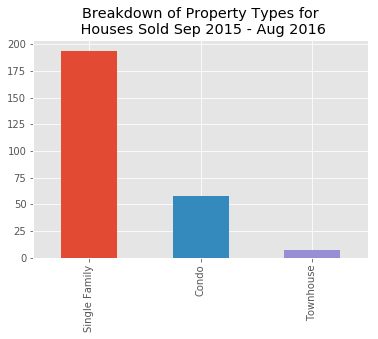

In [5]:
#Task 3.2: bar chart of property type
proptype_bar = houses['PropType'].value_counts().plot(kind='bar', title="Breakdown of Property Types for\n Houses Sold Sep 2015 - Aug 2016")


,Acres,Deck,GaragCap,Latitude,Longitude,LstPrice,Patio,PkgSpacs,SoldPrice,Taxes,TotBed,TotBth,TotSqf,YearBlt
Acres,1.000000,0.306762,0.450829,0.564769,0.244185,0.717858,0.233044,0.175296,0.711439,0.680194,0.594480,0.507625,0.740481,0.100447
Deck,0.306762,1.000000,0.222560,0.363233,-0.003347,0.335889,0.018431,0.096088,0.328356,0.271273,0.193965,0.270497,0.337081,0.209536
GaragCap,0.450829,0.222560,1.000000,0.318712,0.086899,0.633790,0.167365,-0.027842,0.624576,0.627602,0.358544,0.596310,0.571329,0.460636
Latitude,0.564769,0.363233,0.318712,1.000000,-0.251281,0.360129,0.151628,0.169796,0.364374,0.331783,0.289200,0.292262,0.407403,0.325894
Longitude,0.244185,-0.003347,0.086899,-0.251281,1.000000,0.391545,0.128999,0.039165,0.393400,0.361854,0.329669,0.154054,0.290578,-0.234487
LstPrice,0.717858,0.335889,0.633790,0.360129,0.391545,1.000000,0.283964,0.155130,0.995074,0.881673,0.662457,0.737368,0.869847,0.188887
Patio,0.233044,0.018431,0.167365,0.151628,0.128999,0.283964,1.000000,0.032532,0.293628,0.211765,0.131707,0.156261,0.223540,-0.078691
PkgSpacs,0.175296,0.096088,-0.027842,0.169796,0.039165,0.155130,0.032532,1.000000,0.141433,0.086005,0.196911,0.132713,0.181689,-0.171139
SoldPrice,0.711439,0.328356,0.624576,0.364374,0.393400,0.995074,0.293628,0.141433,1.000000,0.876925,0.657785,0.725461,0.859766,0.183947
Taxes,0.680194,0.271273,0.627602,0.331783,0.361854,0.881673,0.211765,0.086005,0.876925,1.000000,0.562733,0.726171,0.818183,0.290078


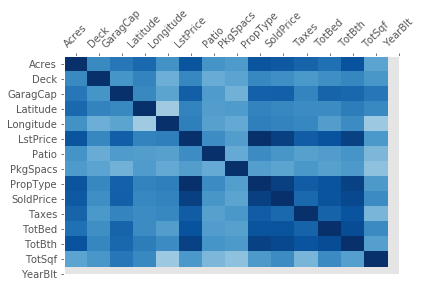

In [6]:
# Task 3.3: calculate and visualize correlations as matrix (for variables given in Task 2.3)
#correlation matrix (w/variables given in Task 2.3)
houses_sub1 = houses[['Acres', 'Deck', 'GaragCap', 'Latitude', 'Longitude', 'LstPrice', 'Patio', 'PkgSpacs', 'PropType', 'SoldPrice', 'Taxes', 'TotBed', 'TotBth', 'TotSqf', 'YearBlt']]
houses_sub1.corr()

#plot the heatmap
fig, ax = plt.subplots()
heatmap_sub1 = ax.pcolor(houses_sub1.corr(), cmap=plt.cm.Blues, vmin=-1, vmax=1)

#invert the plot to have diagonal top left to bottom right
ax.invert_yaxis()
ax.xaxis.tick_top()

#set tick marks
ax.set_xticks(np.arange(len(list(houses_sub1))) + .5, minor=False) # +.5 to center
ax.set_yticks(np.arange(len(list(houses_sub1))) + .5, minor=False)
plt.xticks(rotation=45) #rotate x-labels

#label the plot
ax.set_xticklabels(houses_sub1.columns, minor=False)
ax.set_yticklabels(houses_sub1.columns, minor=False)

houses_sub1.corr()


#reference (this basketball guy saved my life!)
#https://stackoverflow.com/questions/14391959/heatmap-in-matplotlib-with-pcolor


C:\Users\Becca\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: FutureWarning: 'pandas.tools.plotting.scatter_matrix' is deprecated, import 'pandas.plotting.scatter_matrix' instead.
  if __name__ == '__main__':


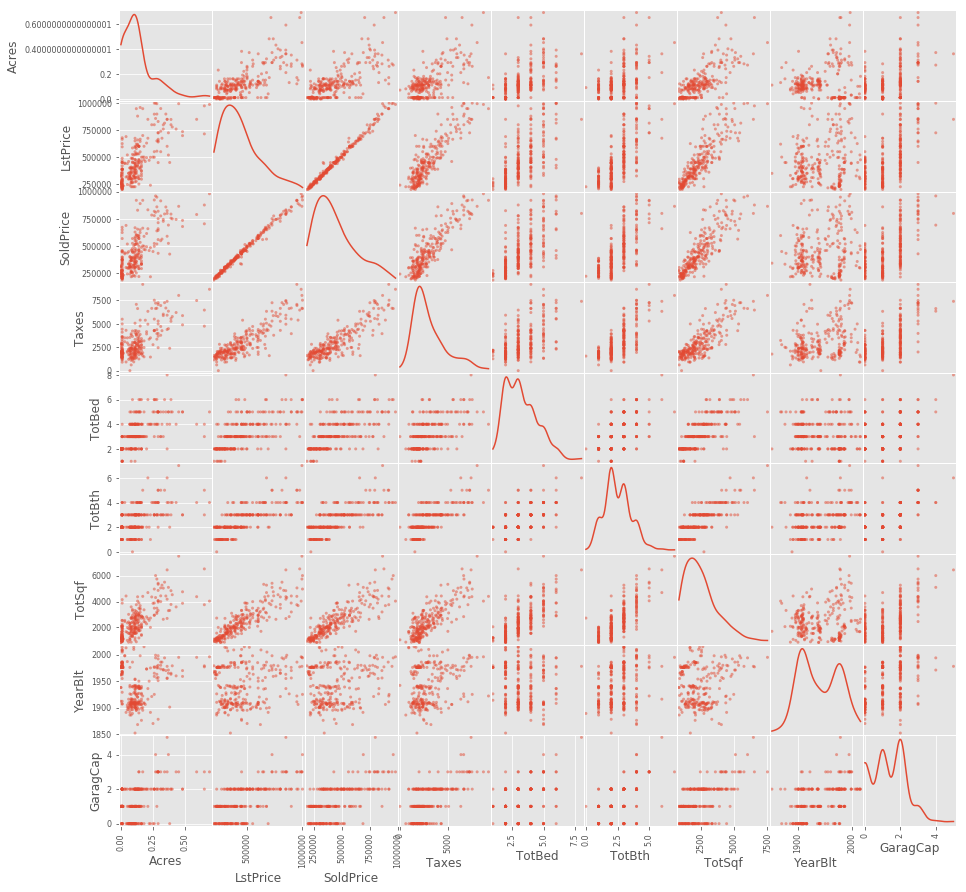

In [7]:
# Task 3.4: scatter plot matrix 

from pandas.tools.plotting import scatter_matrix

#create subset of data 
houses_sub2 = houses[['Acres', 'LstPrice', 'SoldPrice', 'Taxes', 'TotBed', 'TotBth', 'TotSqf', 'YearBlt', 'GaragCap']]

#create scatter plot
scatter_matrix(houses_sub2, figsize=(15, 15), diagonal='kde');


**Your Interpretation: Task 3** 

From the scatter matrix above (and with the visual aid from the heatmap from Task 3.3), we can quickly identify List Price, Sold Price and Taxes as the variables with the strongest positive linear correlation to all other variables. This shouldn't be surprising-- we all know "money talks." It would be odd to see any other correlation with price, as we know from experience that the more acres, bedrooms, bathrooms, and squarefootage a home has, the higher the price (and tax). Which brings us to the fourth-most correlated variable: square footage. We  see a strong positive linear correlation between square footage and the other variables. Interestingly, there is no correlation between the year a house was built and any other variable. Avenues home buyers aren't particularly picky about creaky floors, it seems. 

### Task 4: Geospatial plot
Two of the variables are the latitude and longitude of each listing. Salt Lake City is on this nice east-west, north-south grid, so even a simple plot of lat and long makes sense. Create a scatterplot of these two variables. Use color to indicate the price of the house. How does the price depend on the house location?

Bonus: If you can, overlay the scatterplot on a map of the city. (This is challenging, and we didn't teach you how to do it, so you might do the other parts of the assignment first.)

What can you say about the relation between the location and the house price?

Text(0.5,0,'Longitude')

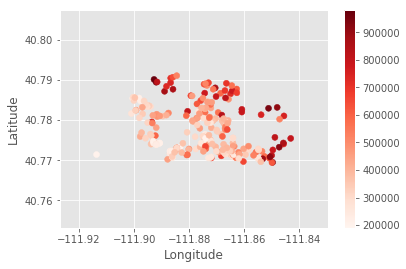

In [8]:
#Task 4: Geospatial plot

#create scatterplot of long vs. lat with dot colors representing price
plt.scatter(houses['Longitude'], houses['Latitude'], c=houses["SoldPrice"], cmap=plt.cm.Reds)
plt.colorbar() #color bar to show price associated w/ color
plt.ylabel("Latitude")
plt.xlabel("Longitude")


**Your Interpretation:** The geospatial plot above provides three points of relevant information regarding houses sold in the Avenues: 1) the longitude of the house's location (i.e. the East-West location); 2) the latitude of the house's location (i.e. North-South location); and 3) the sale price of the house. With the aid of the color bar on the right-hand side of the plot, we can use the plot to determine where the majority of higher-priced homes were sold: those furthest north (lat > 0.025) and those furthest east (long < -0.06). Conversely, the lower-priced homes are congregated further west, particularly south-west. 

### Task 5: Simple  Linear Regression 
Use the 'ols' function from the [statsmodels](http://www.statsmodels.org/stable/index.html) package to regress the Sold price on some of the other variables. Your model should be of the form:
$$
\text{Sold Price} = \beta_0 + \beta_1 x, 
$$
where $x$ is one of the other variables. 

You'll find that the best predictor of sold price is the list price. Report the R-squared value for this model (SoldPrice ~ LstPrice) and give an interpretation for its meaning. Also give an interpretation of $\beta_1$ for this model. Make a plot of list price vs. sold price and overlay the prediction coming from your regression model. 

In [9]:
#Task 5: simple linear regression
#Q: can we predict the effect of variables on sale price?
#Q: which of the variables effects sale price the most?

#regress SoldPrice with other variables
sm.ols(formula = "SoldPrice ~ TotBth", data = houses_sub1).fit().summary() #huge coeff = 1.28e5 
sm.ols(formula = "SoldPrice ~ Taxes", data = houses_sub1).fit().summary() #coef = 99
sm.ols(formula = "SoldPrice ~ Latitude", data = houses_sub1).fit().summary()#pretty huge coeff too, 1.2e7 WTF??

#regress Sold Price with List Price
sold_list_ols = sm.ols(formula = "SoldPrice ~ LstPrice", data = houses_sub1).fit()
sold_list_ols.summary()

# variables for reference
#['Acres', 'Deck', 'GaragCap', 'Latitude', 'Longitude', 'LstPrice', 'Patio', 'PkgSpacs', 'PropType', 'SoldPrice', 'Taxes', 'TotBed', 'TotBth', 'TotSqf', 'YearBlt']

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SoldPrice   R-squared:                       0.990
Model:                            OLS   Adj. R-squared:                  0.990
Method:                 Least Squares   F-statistic:                 2.589e+04
Date:                Fri, 11 May 2018   Prob (F-statistic):          5.36e-260
Time:                        14:22:38   Log-Likelihood:                -2916.4
No. Observations:                 259   AIC:                             5837.
Df Residuals:                     257   BIC:                             5844.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    1.31e+04   2966.224      4.415      0.000    7255.639    1.89e+04
LstPrice       0.9442      0.006    160.914      0.000       0.933       0.956
==============================================================================
Omnibus:                      122.553   Durbin-Watson:                   1.863
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              870.834
Skew:                          -1.747   Prob(JB):                    7.96e-190
Kurtosis:                      11.276   Cond. No.                     1.28e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.28e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

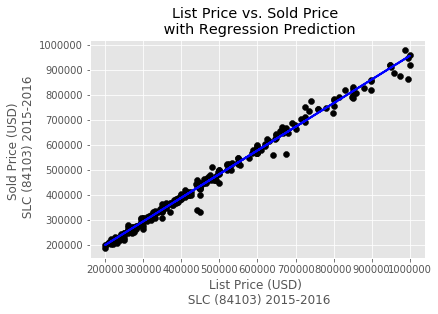

In [10]:
#Task 5 cont.
#plot List Price vs. Sold Price
plt.scatter(x = houses_sub1["LstPrice"], y = houses_sub1["SoldPrice"], c = "black")
plt.xlabel("List Price (USD) \n SLC (84103) 2015-2016")
plt.ylabel("Sold Price (USD) \n SLC (84103) 2015-2016")
plt.title("List Price vs. Sold Price \n with Regression Prediction")
#overlay prediction from regression model
plt.plot(houses_sub1["LstPrice"], sold_list_ols.predict(),'k', color='blue', linewidth = 2)


**Your Interpretation: Task 5** 

The R-squared value for the model Sold Price ~ List Price is 0.99; the model explains 99% of the variability in Sold Price. The coefficient for List Price, $\beta_1$, is 0.94. That is, the slope of the line \text{Sold Price} = \beta_0 + \beta_1 * List Price, is almost 1. We can infer that there is almost a 1-to-1 relationship between Sold Price and List Price; for every unit change in List Price, there is a .94 change in Sold Price.

### Task 6: Multilinear Regression 
Develop a multilinear regression model for house prices in this neighborhood. We could use this to come up with a list price for houses coming on the market, so do not include the list price in your model and, for now, ignore the categorical variable Prop_Type. Your model should be of the form:
$$
\text{Sold Price} = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \cdots +  \beta_n x_n, 
$$
where $x_i$ are predictive variables. Which variables are the best predictors for the Sold Price? 

Specific questions:
1. Often the price per square foot for a house is advertised. Is this what the coefficient for TotSqf is measuring? Provide an interpretation for the coefficient for TotSqf.  
+ Estimate the value that each Garage space adds to a house. 
+ Does latitude or longitude have an impact on house price? Explain. 
+ If we wanted to start a 'house flipping' company, we'd have to be able to do a better job of predicting the sold price than the list price does. How does your model compare? 

In [11]:
#Task 6.1: square ftg and sold price
sm.ols(formula = "SoldPrice ~ TotSqf", data = houses_sub1).fit().summary()

#Variables: Acres, Deck, GaragCap, Latitude, Longitude, Patio, PkgSpacs, Taxes, TotBed, TotBth, TotSqf, YearBlt


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SoldPrice   R-squared:                       0.739
Model:                            OLS   Adj. R-squared:                  0.738
Method:                 Least Squares   F-statistic:                     728.4
Date:                Fri, 11 May 2018   Prob (F-statistic):           5.72e-77
Time:                        14:22:38   Log-Likelihood:                -3341.0
No. Observations:                 259   AIC:                             6686.
Df Residuals:                     257   BIC:                             6693.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1.199e+05   1.37e+04      8.754      0.000    9.29e+04    1.47e+05
TotSqf       133.6396      4.952     26.989      0.000     123.889     143.390
==============================================================================
Omnibus:                       37.086   Durbin-Watson:                   2.056
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               68.353
Skew:                           0.768   Prob(JB):                     1.44e-15
Kurtosis:                       4.994   Cond. No.                     6.27e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.27e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

**Your Interpretation: Task 6.1**

Simplifying the regression of $\text{SoldPrice ~ TotSqf}$ yields an $R^2$ value of 0.74 and a $\beta_1$ value of 133.8. That is, the simple model is a fairly good fit in which the square footage explains 74% of the variance of sold price, and per each unit change in square footage, there is a 134 unit change in sold price (i.e. 1 sqft. increase results in $134 increase in sale price). This coefficient, however, is not the same as the advertised "price per square foot", which is merely a ratio of sale price to square footage. 

Now we'd like to add other variables to our simple $\text{SoldPrice ~ TotSqf}$ model to see whether we can increase our $R^2$ value. That is, will adding different variables improve our model for predicting Sold Price? Which variables should we add? Perhaps the first variables to consider are those *not* to include in our model: those strongly correlated to List Price. Since we have decided not to include List Price in our model due to its (almost perfect) linear correlation to Sold Price, we will also exclude Taxes.

Next, we will choose to include those variables correlated with Total Square Footage: Total Bedrooms, Total Baths, Garage Capacity, Patios and Decks. When each is added individually to our model $tex{SoldPrice ~ TotSqf}$, we see total bathrooms, patios, and garage capacity each increase our $R^2$ value while also maintaining p-values less than .05 (a typical significance level for testing). When we combine all of the variables into our model $\text{SoldPrice ~ TotSqf + TotBth + Patio + GaragCap}$, we increase our $R^2$ value to .776, but our p-value for total bathrooms increases to .2! The best model so far, after comparing $R^2$ values and p-values, is $\text{SoldPrice ~ TotSqf + Patio + GaragCap}$. (See OLS Regression Results below.)

In [12]:
#Task 6: adding variables to SoldPrice ~ TotSqf model (vars correlated to totsqft)
#comments indicate R^2 and p-vals
sm.ols(formula = "SoldPrice ~ TotSqf + TotBed", data = houses_sub1).fit().summary() #.74; 0, .2 --> totbed has no affect on price
sm.ols(formula = "SoldPrice ~ TotSqf + TotBth", data = houses_sub1).fit().summary() #.746; 0, .013
sm.ols(formula = "SoldPrice ~ TotSqf + Patio", data = houses_sub1).fit().summary() #.75; 0, .001
sm.ols(formula = "SoldPrice ~ TotSqf + TotBth + Patio", data = houses_sub1).fit().summary() #.757; 0, .009, .001
sm.ols(formula = "SoldPrice ~ TotSqf + Deck", data = houses_sub1).fit().summary() #.741; 0, .2 --> deck has no effect on price
sm.ols(formula = "SoldPrice ~ TotSqf + GaragCap", data = houses_sub1).fit().summary() #.766; 0, 0
sm.ols(formula = "SoldPrice ~ TotSqf + Patio + TotBth + GaragCap", data = houses_sub1).fit().summary() #.776; 0, .2, .001, 0 --> bath p-val is too high!
sm.ols(formula = "SoldPrice ~ TotSqf + Patio + GaragCap", data = houses_sub1).fit().summary() #.775; 0, .001, 0

#Variables: Acres, Deck, GaragCap, Latitude, Longitude, Patio, PkgSpacs, Taxes, TotBed, TotBth, TotSqf, YearBlt


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SoldPrice   R-squared:                       0.775
Model:                            OLS   Adj. R-squared:                  0.772
Method:                 Least Squares   F-statistic:                     292.5
Date:                Fri, 11 May 2018   Prob (F-statistic):           3.11e-82
Time:                        14:22:38   Log-Likelihood:                -3322.0
No. Observations:                 259   AIC:                             6652.
Df Residuals:                     255   BIC:                             6666.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1.055e+05   1.31e+04      8.058      0.000    7.97e+04    1.31e+05
TotSqf       113.1415      5.699     19.852      0.000     101.918     124.365
Patio       2.746e+04   8487.998      3.235      0.001    1.07e+04    4.42e+04
GaragCap    3.754e+04   7081.758      5.302      0.000    2.36e+04    5.15e+04
==============================================================================
Omnibus:                       38.943   Durbin-Watson:                   1.945
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               74.094
Skew:                           0.790   Prob(JB):                     8.14e-17
Kurtosis:                       5.090   Cond. No.                     6.52e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.52e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

**Interpretation: Task 6.2**

From the model we generated in Task 6.1, $\text{SoldPrice ~ TotSqf + Patio + GaragCap}$, we concluded that patios and garage capacity in addition to square footage improves the predictability of sold price. In particular, for each additional garage space, we expect to see an increase in price by approximately $37,000. Not too shabby!

In [13]:
#Task 6.3: effect of latitude and longitude on price

#regress SoldPrice with Latitude, Longitude individually
#comments indicate r^2 val; p-vals; coeff
sm.ols(formula = "SoldPrice ~ Latitude", data = houses_sub1).fit().summary() #.133; 0; 1.1e7
sm.ols(formula = "SoldPrice ~ Longitude", data = houses_sub1).fit().summary() #.155; 0; 5.3e6

#regress SoldPrice with TotSqf and Lat, Long
sm.ols(formula = "SoldPrice ~ TotSqf + Latitude", data = houses_sub1).fit().summary() #.739; 0, .6 --> high lat p-val!
sm.ols(formula = "SoldPrice ~ TotSqf + Longitude", data = houses_sub1).fit().summary() #.762; 0, 0; 2.1e6
sm.ols(formula = "SoldPrice ~ TotSqf + Latitude + Longitude", data = houses_sub1).fit().summary() #.769; 0, .004, 0

#regress model 6.1 and Lat, Long
sm.ols(formula = "SoldPrice ~ TotSqf + Patio + GaragCap + Latitude", data = houses_sub1).fit().summary() #.775; 0, 0, 0, .756 --> too high!
sm.ols(formula = "SoldPrice ~ TotSqf + Patio + GaragCap + Longitude", data = houses_sub1).fit().summary() #.8; 0, .003, 0, 0
#sm.ols(formula = "SoldPrice ~ TotSqf + Patio + GaragCap + Latitude + Longitude", data = houses_sub1).fit().summary(); #.805; 0, .006, 0, .021, 0


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SoldPrice   R-squared:                       0.801
Model:                            OLS   Adj. R-squared:                  0.797
Method:                 Least Squares   F-statistic:                     255.0
Date:                Fri, 11 May 2018   Prob (F-statistic):           1.17e-87
Time:                        14:22:38   Log-Likelihood:                -3306.2
No. Observations:                 259   AIC:                             6622.
Df Residuals:                     254   BIC:                             6640.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   2.566e+08   4.48e+07      5.734      0.000    1.68e+08    3.45e+08
TotSqf       104.0992      5.600     18.588      0.000      93.070     115.128
Patio       2.405e+04   8024.947      2.997      0.003    8246.741    3.99e+04
GaragCap    4.157e+04   6713.777      6.191      0.000    2.83e+04    5.48e+04
Longitude   2.293e+06      4e+05      5.732      0.000     1.5e+06    3.08e+06
==============================================================================
Omnibus:                       35.053   Durbin-Watson:                   1.936
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               82.853
Skew:                           0.637   Prob(JB):                     1.02e-18
Kurtosis:                       5.460   Cond. No.                     2.33e+07
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.33e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

**Interpretation: Task 6.3**

Beginning with our model from Task 6.1, $\text{SoldPrice ~ TotSqf + Patio + GaragCap}$, we add both latitude and longitude, but first individually. After adding latitude to our model $\text{SoldPrice ~ TotSqf + Patio + GaragCap + Latitude}$, we notice no improvement in our $R^2$ value, and a very large p-value for latitude. Hence, latitude does not have an effect on sold price. We then add longitude to our model $\text{SoldPrice ~ TotSqf + Patio + GaragCap + Longitude}$ and notice an improvement in our $R^2$ value from .75 to .805. Longitude improved our ability to predict sold price! 

Looking back at our geospatial map of houses sold, we can now recognize how much more important living further east is than living further north when determining the sale price of a home. It must be because people like living closer to all the attractive U students!

**Interpretation: Task 6.4**

Comparing our new model $\text{SoldPrice ~ TotSqf + Patio + GaragCap + Longitude}$ to the simple linear regression model $\text{SoldPrice ~ ListPrice}$ simply on the basis of $R^2$ values, we can conclude that our model is underperforming. That is, our model only accounts for 80% of the variability in sold price, whereas the simple list price model accounts for 99% of variability. But, considering our goal is to create accurate list prices for the purpose of flipping houses (that is, we wouldn't know the list price), then our model would be able to predict approximately 80% of the sale price. Though the model seems fairly successful, we probably shouldn't start such a house-flipping business simply after one regression exercise.  


### Task 7: Incorporating a categorical variable

Above, we considered houses, townhouses, and condos together, but here we'll distinguish between them. Consider the two regression models: 
$$
\text{SoldPrice} = \beta_0 + \beta_1 \text{Prop_Type_num}
$$
and 
$$
\text{SoldPrice} = \beta_0  + \beta_1 \text{Prop_Type_num} + \beta_2 \text{TotSqf}
$$
From the first model, it would appear that Property type is significant in predicting the sold price. On the other hand, the second model indicates that when you take into account total square footage, property type is no longer predictive. Explain this. (Hint: there is a confounder lurking here.) Make a scatterplot of TotSqf vs. SoldPrice where the house types are colored differently to illustrate your explanation. 

                            OLS Regression Results                            
Dep. Variable:              SoldPrice   R-squared:                       0.159
Model:                            OLS   Adj. R-squared:                  0.156
Method:                 Least Squares   F-statistic:                     48.54
Date:                Fri, 11 May 2018   Prob (F-statistic):           2.70e-11
Time:                        14:22:39   Log-Likelihood:                -3492.7
No. Observations:                 259   AIC:                             6989.
Df Residuals:                     257   BIC:                             6996.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept       3.21e+05   2.17e+04     14.823

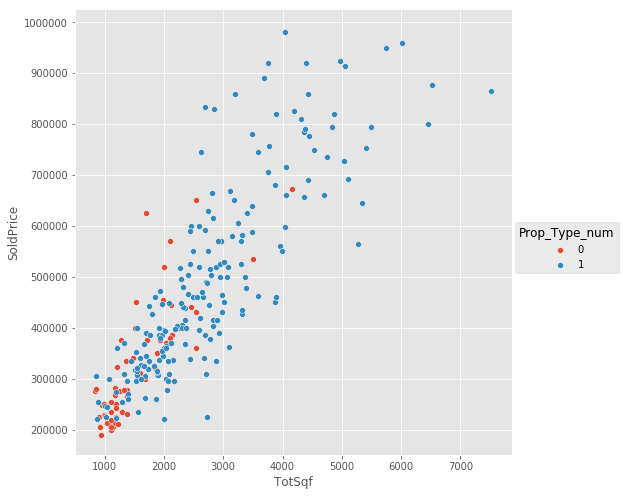

In [14]:
#Task 7: incorporating categorical variable
import seaborn as sea

#model sold price ~ prop type num
print(sm.ols(formula = "SoldPrice ~ Prop_Type_num", data = houses).fit().summary()) #R^2 is really low :(
#model sold price ~ prop type num + sqft
print(sm.ols(formula = "SoldPrice ~ Prop_Type_num + TotSqf", data = houses).fit().summary())

#plot sqft vs sold price w/ house types as colors
houses_sub3 = houses[['Prop_Type_num', 'TotSqf','SoldPrice']]
sea.pairplot(data = houses_sub3, hue = 'Prop_Type_num', x_vars=['TotSqf'], y_vars=['SoldPrice'], size = 7)

#in order to get correct legend, I would have needed to plot both individually...eff that
#sqft_price_type = plt.scatter(houses['TotSqf'], houses['SoldPrice'], c=houses["Prop_Type_num"])
#plt.xlabel("Total Square Footage of House")
#plt.ylabel("Sold Price of House (USD)")


**Your Interpretation: Task 7** 

In the model $\text{SoldPrice ~ Prop_Type_num}$, we notice that property type is significant in predicting sold price (despite only having an $R^2$ value of .159). Interestingly, when we regress sold price with property type and square footage $\text{SoldPrice ~ Prop_Type_num + TotSqf}$, we see that property type no longer has a significant effect on predicting the sold price. That categorical variable, property type, is a confounder! From the scatterplot above, we can clearly identify two groups (Townhouses/Condos and SFH) and their differing distributions. Becuase there are two distinct groups with the majority of one group clearly lyinging below $50,000 price, we know that total square footage of a home rather than the type of home more accurately predicts the price. 